In [7]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [8]:
# =====================================
# STEP 2: Load Titanic Dataset
# =====================================
train = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv', index_col='PassengerId')
# For test, we'll use a subset or the same for demonstration
test = train.sample(frac=0.2, random_state=42)  # Sample 20% for test
train = train.drop(test.index)

print(train.head())

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S

In [9]:
# =====================================
# STEP 3: Basic Cleaning
# =====================================
train.drop(['Name'], axis=1, inplace=True)
print(train.isna().sum())

Survived      0
Pclass        0
Sex           0
Age         140
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       553
Embarked      2
dtype: int64


In [10]:
# =====================================
# STEP 4: Encoding Categorical Variables
# =====================================
# 4.1 Encode Sex
train_sex = pd.get_dummies(train['Sex'])
train2 = pd.concat([train, train_sex], axis=1)
train2.drop(['Sex'], axis=1, inplace=True)

# 4.2 Encode Embarked
train_Embarked = pd.get_dummies(train2['Embarked'])
train3 = pd.concat([train2, train_Embarked], axis=1)
train3.drop(['Embarked', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [11]:
# =====================================
# STEP 5: Handle Missing Values
# =====================================
mean_age = train3['Age'].mean()
train3['Age'].replace(np.nan, mean_age, inplace=True)

/tmp/ipykernel_8872/3333612345.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train3['Age'].replace(np.nan, mean_age, inplace=True)


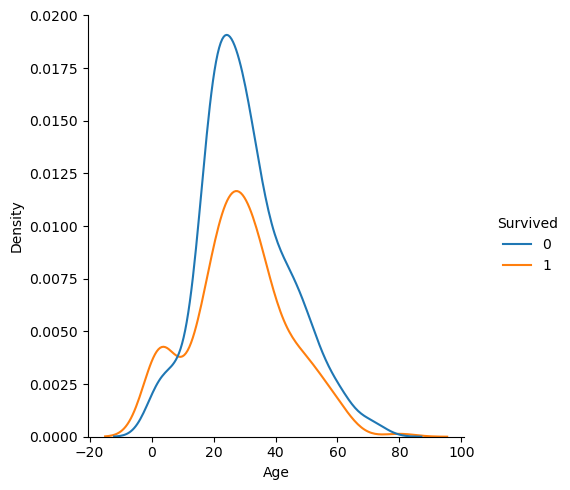

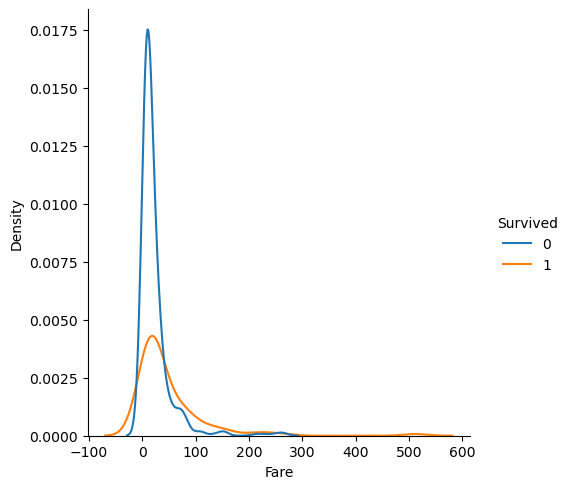

In [12]:
# =====================================
# STEP 6: Exploratory Data Analysis (EDA)
# =====================================
sns.displot(train, x="Age", hue="Survived", kind="kde")
sns.displot(train, x="Fare", hue="Survived", kind="kde")
plt.show()

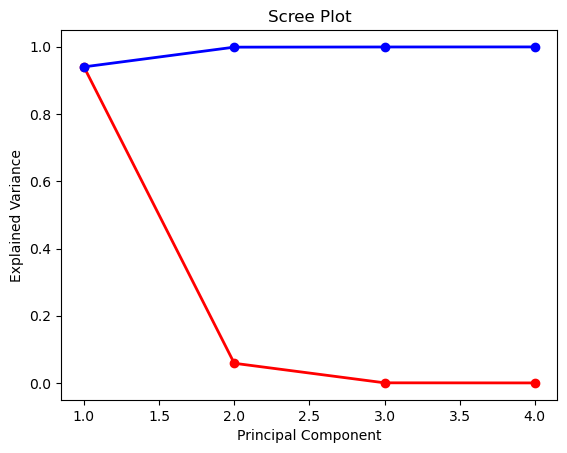

[9.40269598e-01 5.86546179e-02 4.93454901e-04 1.80455381e-04]
           0         1         2         3
0 -25.484353 -6.881180  0.221395 -0.751664
1  38.919597  7.661983  0.188694  0.490433
2 -24.718039 -2.884337 -0.481850  0.522125
3  20.670059  5.083107  0.288704  0.523821
4 -24.389561  6.113271 -0.331490 -0.467775


In [13]:
# =====================================
# STEP 7: PCA for Dimensionality Reduction
# =====================================
num_components = 4
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(train3[["Pclass","Age","SibSp","Parch","Fare","female","male","C","Q","S"]])

# Scree Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.plot(PC_values, pca.explained_variance_ratio_.cumsum(), 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

pca_data2 = pd.DataFrame(pca_data)
print(pca.explained_variance_ratio_)
print(pca_data2.head())

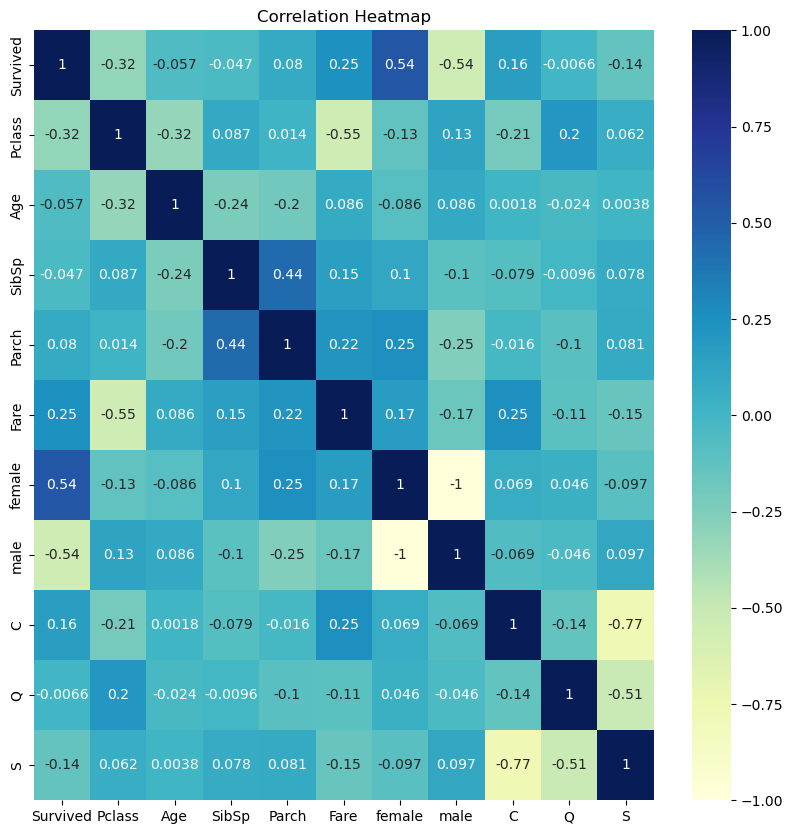

In [14]:
# =====================================
# STEP 8: Feature Selection via Correlation
# =====================================
plt.figure(figsize=(10, 10))
sns.heatmap(train3.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [15]:
# =====================================
# STEP 9: Feature Engineering (Custom Features)
# =====================================

# Flag feature combining Age & Sex
def flags(df):
    if ((df["Age"] >= 40) & (df["female"] == 1)):
        return 4
    elif ((df["Age"] >= 0) & (df["Age"] <= 18) & (df["female"] == 1)):
        return 4
    elif ((df["Age"] < 40) & (df["Age"] > 18) & (df["female"] == 1)):
        return 3
    elif ((df["Age"] >= 40) & (df["female"] == 0)):
        return 2
    else:
        return 1

train3["age_and_sex"] = train3.apply(flags, axis=1)

In [16]:
# =====================================
# STEP 10: WoE & IV for age_and_sex
# =====================================
a = pd.crosstab(train3["age_and_sex"], train3["Survived"], margins=True, margins_name="Total")

total_nonevent = a[0]["Total"]
total_event = a[1]["Total"]

def nonevent(df):
    return (df[0] / total_nonevent)

def event(df):
    return (df[1] / total_event)

a["%nonevent"] = a.apply(nonevent, axis=1)
a["%event"] = a.apply(event, axis=1)
a["WoE"] = np.log(a["%nonevent"] / a["%event"])
a["IV"] = (a["%nonevent"] - a["%event"]) * a["WoE"]

print(a)
print("Total IV (age_and_sex):", a["IV"].sum())

Survived       0    1  Total  %nonevent    %event       WoE        IV
age_and_sex                                                          
1            306   73    379   0.689189  0.271375  0.932012  0.389408
2             74   14     88   0.166667  0.052045  1.163895  0.133408
3             38  113    151   0.085586  0.420074 -1.590915  0.532143
4             26   69     95   0.058559  0.256506 -1.477123  0.292392
Total        444  269    713   1.000000  1.000000  0.000000  0.000000
Total IV (age_and_sex): 1.347350856653323


In [17]:
# =====================================
# STEP 11: WoE & IV for Fare Category
# =====================================
def fare_flag(df):
    if df["Fare"] >= 35:
        return 3
    elif df["Fare"] >= 20:
        return 2
    else:
        return 1

train3["fare_category"] = train3.apply(fare_flag, axis=1)

b = pd.crosstab(train3["fare_category"], train3["Survived"], margins=True, margins_name="Total")
total_nonevent = b[0]["Total"]
total_event = b[1]["Total"]

b["%nonevent"] = b.apply(lambda x: x[0]/total_nonevent, axis=1)
b["%event"] = b.apply(lambda x: x[1]/total_event, axis=1)
b["WoE"] = np.log(b["%nonevent"]/b["%event"])
b["IV"] = (b["%nonevent"] - b["%event"])*b["WoE"]

print(b)
print("Total IV (fare_category):", b["IV"].sum())

Survived         0    1  Total  %nonevent    %event       WoE        IV
fare_category                                                          
1              297  119    416   0.668919  0.442379  0.413495  0.093673
2               82   56    138   0.184685  0.208178 -0.119746  0.002813
3               65   94    159   0.146396  0.349442 -0.870021  0.176654
Total          444  269    713   1.000000  1.000000  0.000000  0.000000
Total IV (fare_category): 0.2731406346950342


In [18]:
# =====================================
# STEP 12: SelectKBest (ANOVA)
# =====================================
X = train3.drop(columns=['Survived'])
y = train3['Survived']
X_new = SelectKBest(f_regression, k=5).fit_transform(X, y)
print(X_new[:5])

[[3. 0. 1. 1. 1.]
 [1. 1. 0. 3. 3.]
 [3. 1. 0. 3. 1.]
 [1. 1. 0. 3. 3.]
 [3. 0. 1. 1. 1.]]


In [19]:
# =====================================
# STEP 13: RFE (Wrapper Method)
# =====================================
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y)
print("Selected Features by RFE:", rfe.support_)

Selected Features by RFE: [ True False False False False  True  True False False  True  True False]


In [20]:
# =====================================
# STEP 14: Embedded Methods (Lasso & Random Forest)
# =====================================
lasso = Lasso(alpha=0.01)
lasso.fit(X.fillna(0), y)
print("Lasso Coefficients:", lasso.coef_)

rf_model = RandomForestRegressor()
rf_model.fit(X.fillna(0), y)
importance = rf_model.feature_importances_
print("Feature Importances (RandomForest):", importance)

Lasso Coefficients: [-1.33053422e-01 -5.12369919e-03 -3.89631287e-02 -4.95072355e-03
  6.26266088e-04  3.60004593e-01 -2.32621692e-15  0.00000000e+00
  0.00000000e+00 -2.00518670e-02  4.85138106e-02  0.00000000e+00]
Feature Importances (RandomForest): [0.10528414 0.22951935 0.04989181 0.02127039 0.24172858 0.12160768
 0.10106184 0.01192592 0.00568434 0.01362743 0.09078614 0.00761236]
